# same with extractRrs.ipynb, but cleaned

In [1]:
#import
import pandas as pd
import numpy as np
from pyproj import Proj, Transformer
from concurrent import futures
import os
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
import rioxarray as rxr

In [2]:
def readTif_onlyWater(path_to_image):
    """
    path_to_image = "../satelliteImage/Sentinel2_L2A_MississippiS501.tif"
    """
    image = rxr.open_rasterio(path_to_image)
    image = image.where(image>0, drop=True)
    image.isel(band=0).plot() #6.0s

    return image

In [5]:
def tifPointsToxy(image):
    #xy座標への変換
    future_list = []
    with futures.ProcessPoolExecutor(os.cpu_count()) as executor:
        for lat,lon in zip(image.y.values,image.x.values):
            future = executor.submit(latlon_to_xy,lat,lon)
            future_list.append(future)

    x_points = [f.result()[0] for f in future_list]
    y_points = [f.result()[1] for f in future_list]

    return x_points,y_points

In [6]:
projection_to_epsg3857 = Transformer.from_crs('epsg:4326', "epsg:3857")
def latlon_to_xy(lat, lon):

    x,y = projection_to_epsg3857.transform(lat,lon)
    return x, y

In [7]:
def readRivCenterLine(path_to_RivCenterLine,clip=[38.60284134429668,38.99242639934311,-90.45334533854292,-90.04685118281743]):
    """
    csvファイルを読み込み、lat,lonをx,yに変換し、dfを返す
    filePath = "../dat_satellite/RivCenterLine_MS_sparse.csv"
    """
    ## read csv
    df = pd.read_csv(path_to_RivCenterLine)

    ## extract by clip
    df = df.query(f'{clip[0]}<latitude < {clip[1]} & {clip[2]}<longitude<{clip[3]}')
    df = df.reset_index(drop=True)

    future_list = []
    with futures.ProcessPoolExecutor(os.cpu_count()) as executor:
        for lat,lon in zip(df["latitude"],df["longitude"]):
            future = executor.submit(latlon_to_xy,lat,lon)
            future_list.append(future)

    x = [f.result()[0] for f in future_list]
    y = [f.result()[1] for f in future_list]
    points = np.array([[x0,y0] for x0,y0 in zip(x,y)])

    df["x"] = x
    df["y"] = y

    return df

In [8]:
def degToLatLon(hour,min,sec):
    return hour+min/60+sec/3600

In [9]:
def findNeighbors(points,centerpoint,k_neighbors=5,):
    """
    観測地点（河川のある一地点）から距離の近い点をK_neighbors個だけ選択する
    """
    nbrs = NearestNeighbors(n_neighbors=k_neighbors, algorithm='auto').fit(points)
    distances, indices = nbrs.kneighbors([centerpoint])
    indices = indices[0]

    return indices

In [10]:

def point_in_quadrilateral_vectorized(x_points, y_points, quadrilateral_points):
    """
    ベクトル演算を使用して、四角形領域の内部に複数の点が存在するかどうかを判定する関数

    Parameters:
        x_points, y_points: テストする点の座標 (配列)
        quadrilateral_points: 四角形の頂点の座標 [(x1, y1), (x2, y2), (x3, y3), (x4, y4)]

    Returns:
        np.array: 各点が四角形の内部にあるかどうかを示すブール値の配列
    """
    # 四角形の各辺に対して、点が左側（外側）か右側（内側）にあるかを判定
    sides = np.array([
        (quadrilateral_points[i][0] - quadrilateral_points[i - 1][0]) * (y_points - quadrilateral_points[i - 1][1]) -
        (x_points - quadrilateral_points[i - 1][0]) * (quadrilateral_points[i][1] - quadrilateral_points[i - 1][1])
        for i in range(len(quadrilateral_points))
    ])

    # 各点が四角形の内部にあるかどうかを判定
    result = np.logical_or(np.all(sides >= 0, axis=0), np.all(sides <= 0, axis=0))

    return result

In [ ]:
def spectrum_extract(image,boolMatrix):
    """
    boolMatrix=Trueの点のspectrumをListにして渡す
    """
    spectrum = []
    for y in range(len(image.x.values)):
        for x in range(len(image.x.values)):
            
            if boolMatrix[x,y]:
                spectrum.append(image[:,x,y].values)
    return spectrum

In [40]:
def findSpectrumInBuffer(df,indices,image,x_points,y_points,buffer=100):
    df = df[df.index.isin(indices)]
    ## read raster
    x_points,y_points = np.meshgrid(x_points,y_points)

    # empty result list
    spectrum = []

    #start iteration for each index
    for i,index in enumerate(indices):

        ##set parameters
        theta = df["orthogonal"][index] #in radians
        w = df["width"][index]
        cos = np.cos(theta)
        sin = np.sin(theta)
        center = np.array([df["x"][index],df["y"][index]])

        ## determine the apex of the rectangular
        p1 = center + np.array([w*cos + buffer*sin, w*sin - buffer*cos])
        p2 = center + np.array([w*cos - buffer*sin, w*sin + buffer*cos])
        p3 = 2 * center - p1
        p4 = 2 * center - p2
        quadrilateral_points = [p1,p2,p3,p4]

        ## make bool matrix
        result = point_in_quadrilateral_vectorized(x_points, y_points, quadrilateral_points)

        ## add
        res = spectrum_extract(image,result)
        spectrum += res

    return spectrum

In [32]:
def plot_spectrum(spectrumInBuffer):
    fig,ax  = plt.subplots()
    spectrum = []
    for res in spectrumInBuffer:
        ax.plot(res)
        spectrum.append(res)
    plt.show()
    return spectrum

In [41]:
def ave_spectrum(spectrum):
    ave = []
    for i in range(len(spectrum[0])):
        sum = 0
        for j in range(len(spectrum)):
            sum += spectrum[j][i]
        ave.append(sum/len(spectrum))
    return ave

### 実行

In [35]:
MO = [degToLatLon(38.,47.,13.9), degToLatLon(-90.,-28.,-18.5)]
MO = latlon_to_xy(MO[0], MO[1])

In [36]:
def main(obsPoint):
    ## prepare tif
    
    path_to_image = "../satelliteImage/Sentinel2_L2A_MississippiS501.tif"
    print(f"Start read tif:{path_to_image}")
    image = readTif_onlyWater(path_to_image)
    x_points_image,y_points_image = tifPointsToxy(image)

    ## read riverCenterLine
    path_to_RivCenterLine = "../dat_satellite/RivCenterLine_MS_sparse.csv"
    print(f"Start read River Center Line:{path_to_RivCenterLine}")
    df = readRivCenterLine(path_to_RivCenterLine)

    ## find near points for observation point
    rivCenterPoints = np.array([[x0,y0] for x0,y0 in zip(df["x"],df["y"])])
    index = findNeighbors(rivCenterPoints,obsPoint,k_neighbors=5)

    ## start buffering
    print(f"Start Buffering")
    spectrumInBuffer = findSpectrumInBuffer(df,index,image,x_points_image,y_points_image,buffer=100)
    spectrum = plot_spectrum(spectrumInBuffer)

    return spectrum

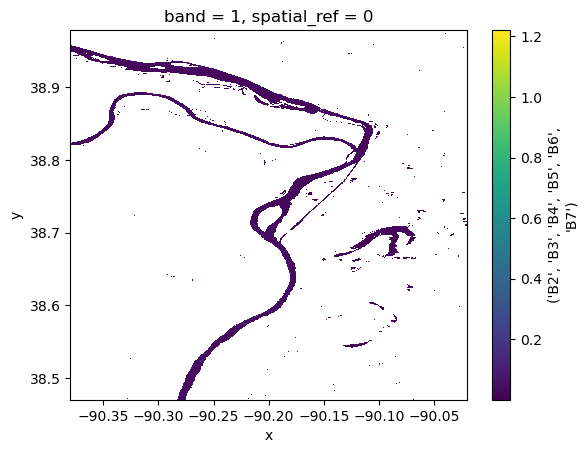

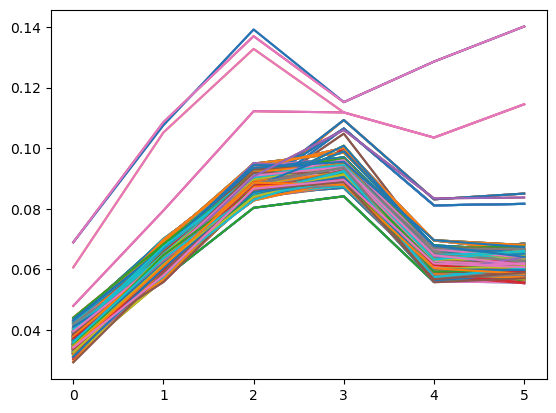

In [43]:
result = main(MO)

In [44]:
spectrum = []
for res in result:
    if res[3] < 0.10:
        spectrum.append(res)

In [45]:
ave_spectrum(spectrum)

[0.03611094339622643,
 0.06207823899371074,
 0.08722000000000002,
 0.09123672955974858,
 0.06068427672955991,
 0.06039471698113217]